<center><img src='https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/SIIM-ISIC%20Melanoma%20Classification/banner.png' height="350"></center>
<p>
<h1><center> SIIM-ISIC Melanoma Classification </center></h1>
<h2><center> Melanoma Classification - Augmentations EDA </center></h2>

#### The idea of this notebook is to provide a simple and modular way to analyze and explore different kinds of augmentations and its parameters.

## Dependencies

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets

# Model parameters

In [2]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 64,
  "AUGMENTED_SAMPLES": 3,
  "DATASET_PATH": 'melanoma-256x256'
}

config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 64,
 'AUGMENTED_SAMPLES': 3,
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(database_base_path + 'train.csv')

print('Train samples: %d' % len(train))
display(train.head())

GCS_PATH = KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TRAINING_FILENAMES = TRAINING_FILENAMES[1] # sample

Train samples: 33126


image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

# Augmentations

In [4]:
def data_augment_spatial(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image, label

def data_augment_rotate(image, label):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image, label

def data_augment_crop(image, label):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .8:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
    elif p_crop > .6:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
    elif p_crop > .4:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    elif p_crop > .2:
        image = tf.image.central_crop(image, central_fraction=.8)
    else:
        image = tf.image.central_crop(image, central_fraction=.7)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image, label

def data_augment_rotation(image, label, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
        
    return image, label

def data_augment_shift(image, label):
    image = transform_shift(image, config['HEIGHT'], 50., 50.)
    return image, label

def data_augment_shear(image, label):
    image = transform_shear(image, config['HEIGHT'], 25.)
    return image, label

def data_augment_hue(image, label):
    image = tf.image.random_hue(image, 0.02)
    return image, label

def data_augment_saturation(image, label):
    image = tf.image.random_saturation(image, 0.8, 1.2)
    return image, label

def data_augment_contrast(image, label):
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

def data_augment_brightness(image, label):
    image = tf.image.random_brightness(image, 0.1)
    return image, label

def data_augment_cutout(image, label):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], min_mask_size=(10, 10), max_mask_size=(80, 80), k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], min_mask_size=(10, 10), max_mask_size=(80, 80), k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], min_mask_size=(10, 10), max_mask_size=(80, 80), k=1)
        
    return image, label

def data_augment(image, label):
    image, label = data_augment_spatial(image, label)
    image, label = data_augment_rotate(image, label)
    image, label = data_augment_crop(image, label)
    image, label = data_augment_rotation(image, label)
    image, label = data_augment_shift(image, label)
    image, label = data_augment_shear(image, label)
    image, label = data_augment_hue(image, label)
    image, label = data_augment_saturation(image, label)
    image, label = data_augment_contrast(image, label)
    image, label = data_augment_brightness(image, label)
    
    return image, label

## Auxiliary functions

In [5]:
# Datasets utility functions
LABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "target": tf.io.FixedLenFeature([], tf.int64), # shape [] means single element
}

def decode_image(image_data, height, width, channels):
    image = tf.image.decode_jpeg(image_data, channels=channels)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [height, width, channels])
    return image

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    
    return image, label # returns a dataset of (image, data, label)

def load_dataset(filenames, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_display(filenames):
    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval,)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_display_dataset(filenames, batch_size=32):
    dataset = load_dataset_display(filenames)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    return dataset

def display_augmentation(dataset, n_samples, augmentation, rows=2, cols=7):
    dataset_elements = iter(dataset)
    for sample in range(n_samples):
        element = tf.data.Dataset.from_tensors(next(dataset_elements))
        element_augmented = element.repeat().map(augmentation).batch(rows*cols)
        for (img, label) in element_augmented:
            plt.figure(figsize=(15, int(15*rows/cols)))
            for j in range(rows*cols):
                plt.subplot(rows, cols, j+1)
                plt.axis('off')
                plt.imshow(img[j,])
            plt.show()
            break

In [6]:
# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.uniform([1],dtype='float32') 
    width_shift = w_shift * tf.random.uniform([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape(tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# Display images

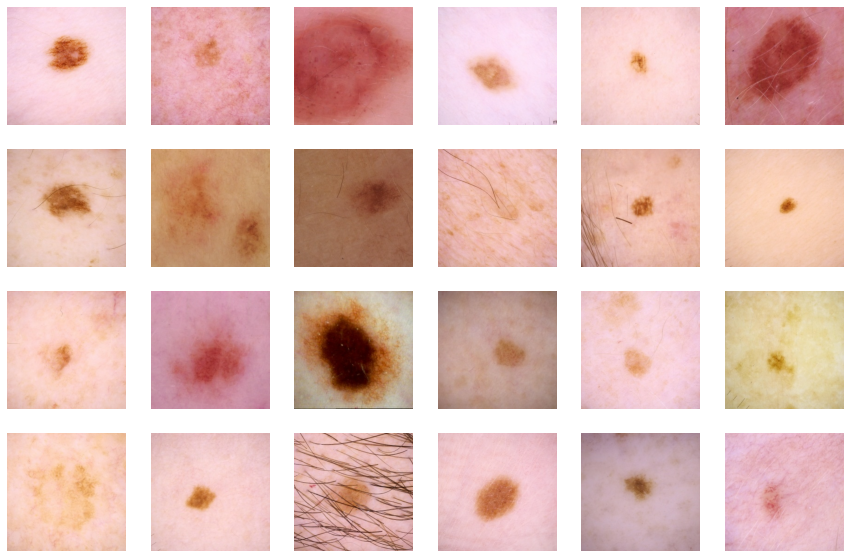

In [7]:
row = 4; col = 6;
all_elements = get_display_dataset(TRAINING_FILENAMES).unbatch()
batch_element = all_elements.repeat().batch(row*col)

for (img, label) in batch_element:
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# Spatial augmentation

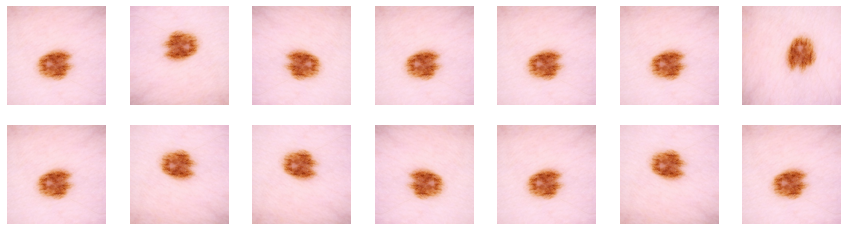

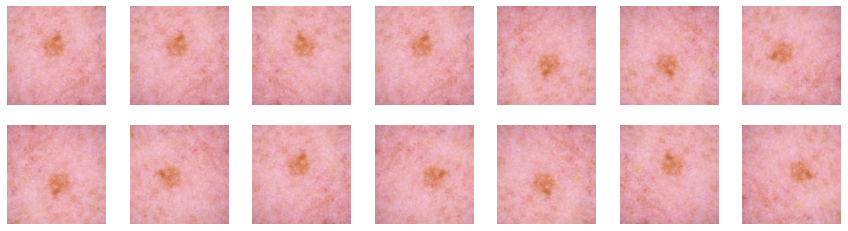

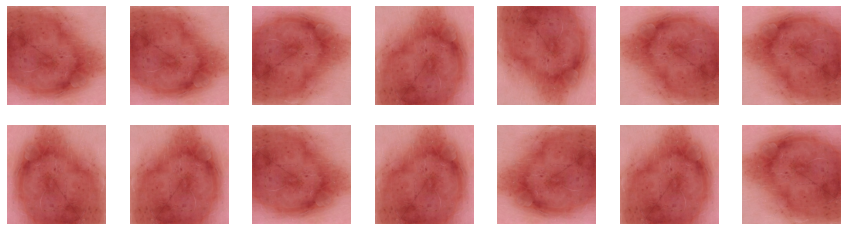

In [8]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())            
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_spatial)

# Rotates augmentation

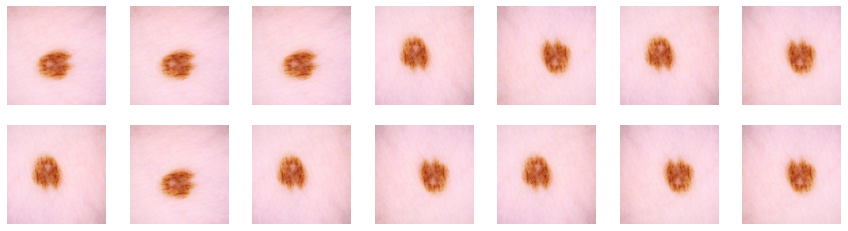

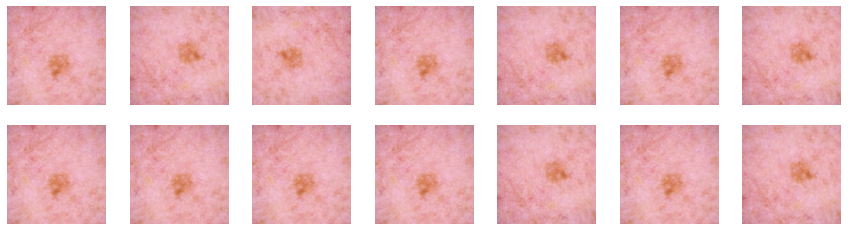

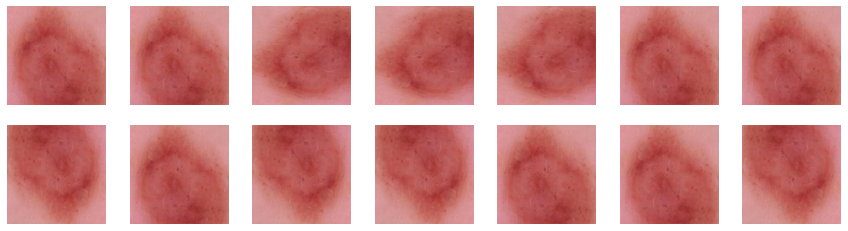

In [9]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_rotate)

# Crop augmentation

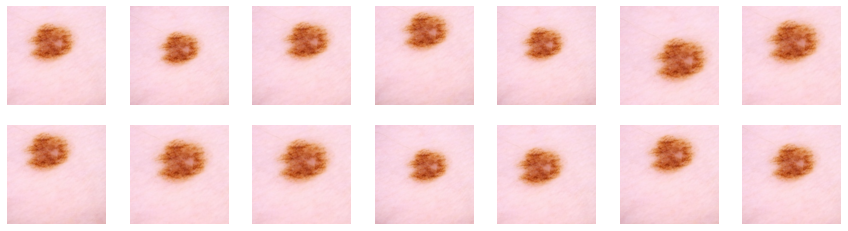

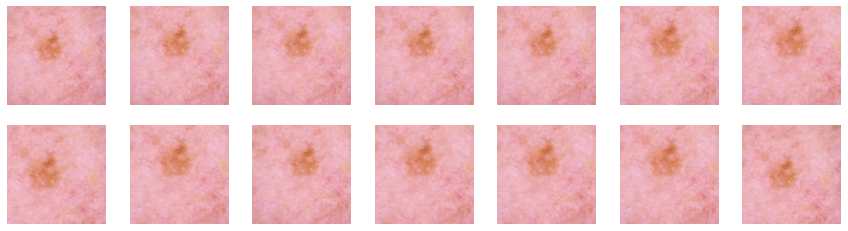

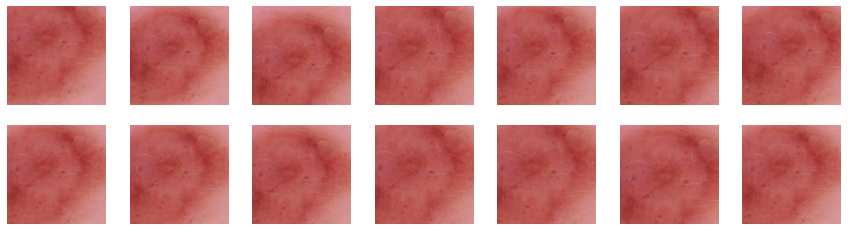

In [10]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_crop)

# Rotation augmentation

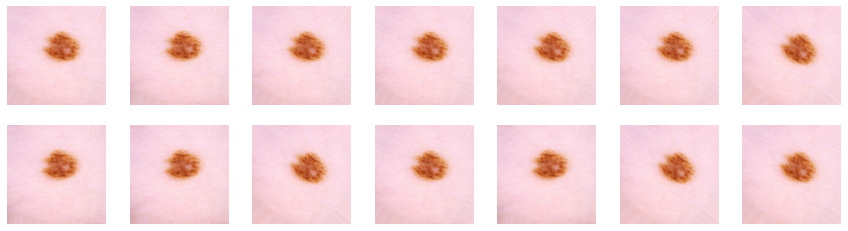

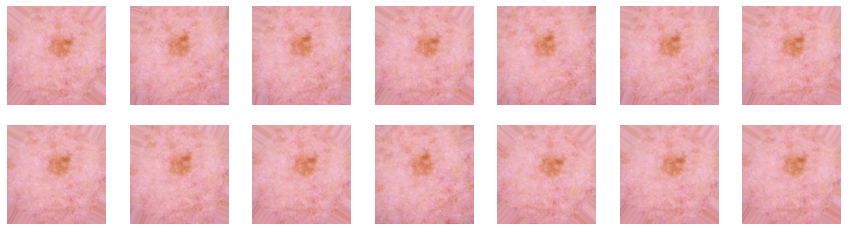

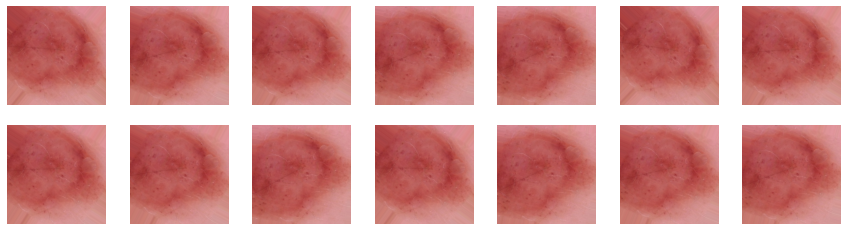

In [11]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_rotation)

# Shift augmentation

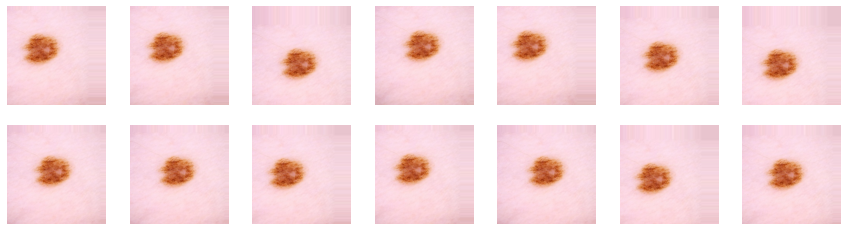

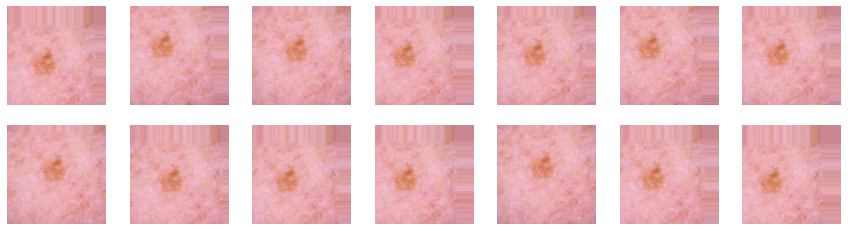

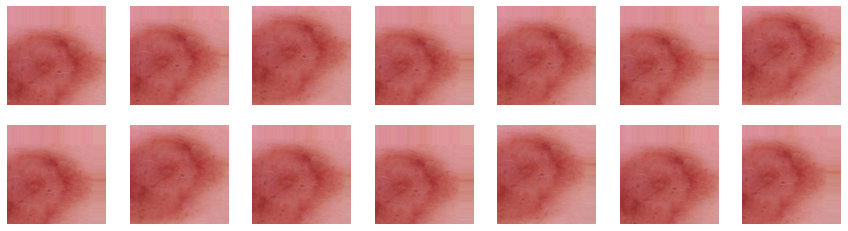

In [12]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_shift)

# Shear augmentation

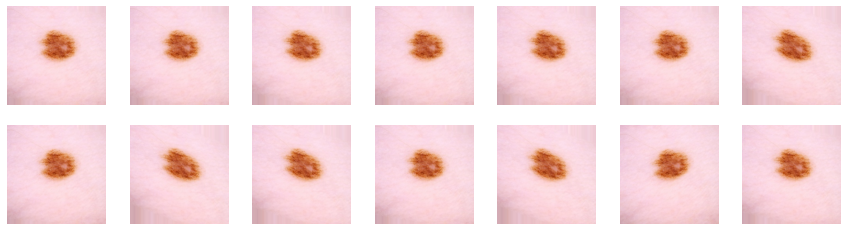

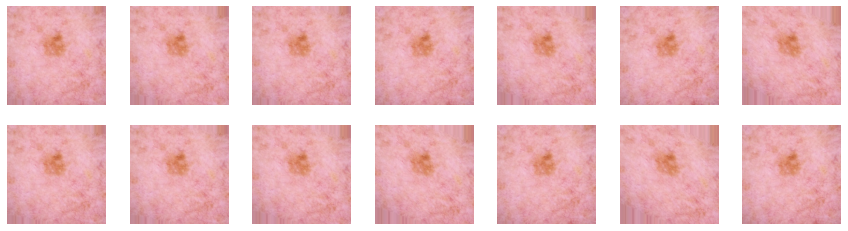

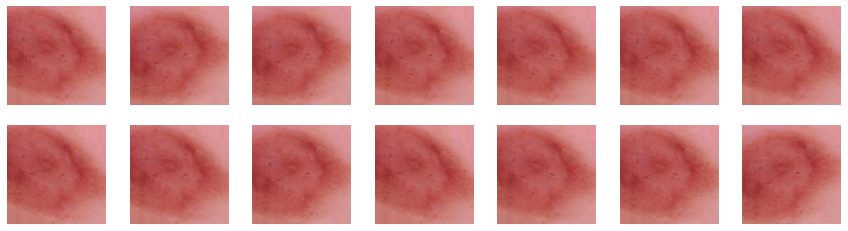

In [13]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_shear)

# HUE augmentation

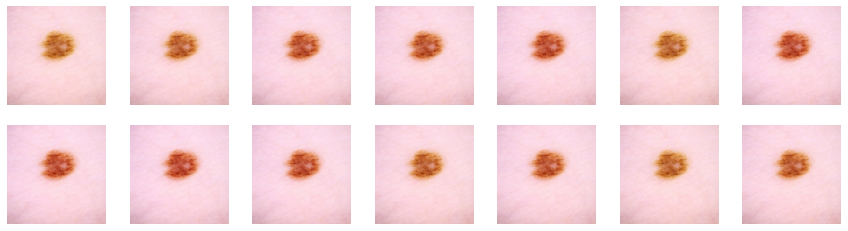

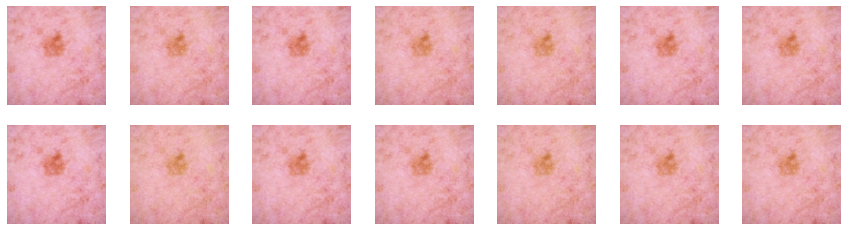

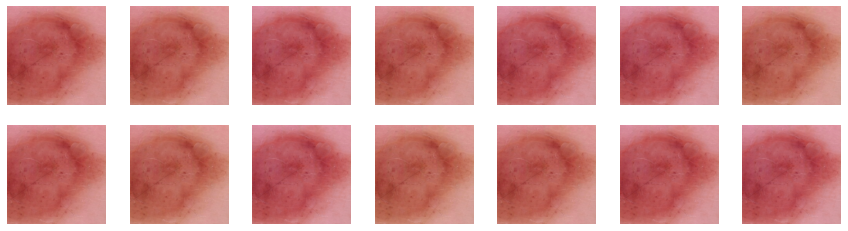

In [14]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_hue)

# Saturation augmentation

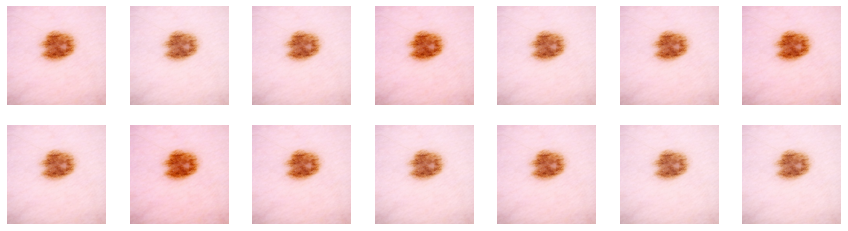

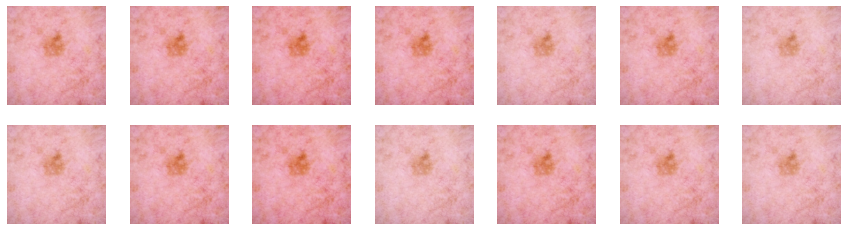

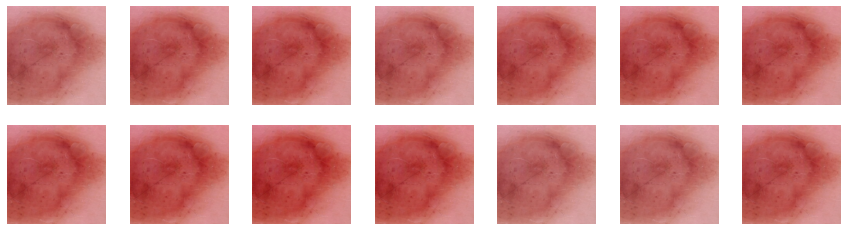

In [15]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_saturation)

# Contrast augmentation

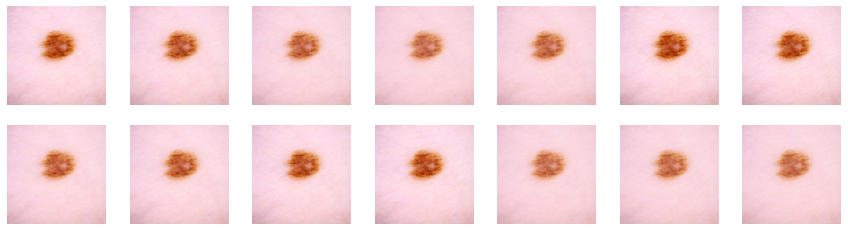

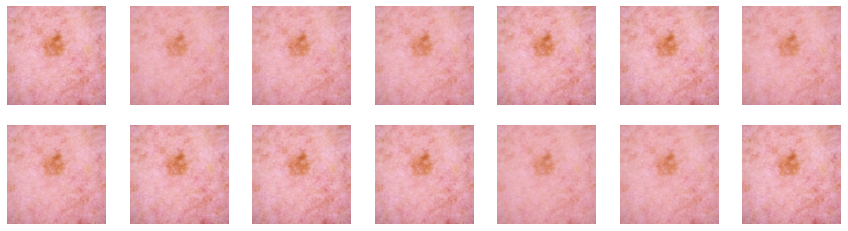

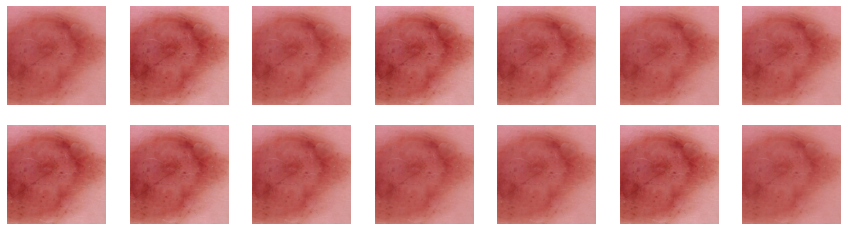

In [16]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_contrast)

# Brightness augmentation

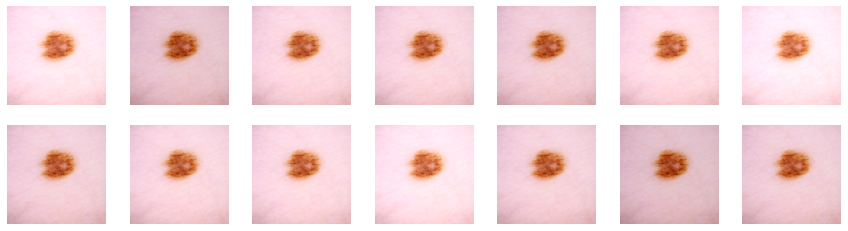

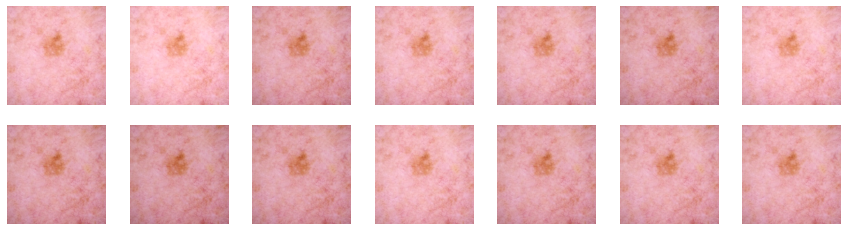

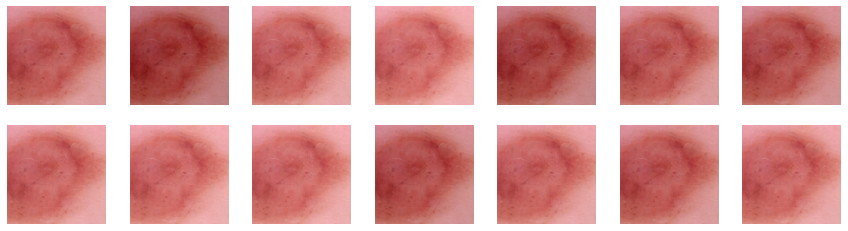

In [17]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, config['AUGMENTED_SAMPLES'], data_augment_brightness)

# All augmentations

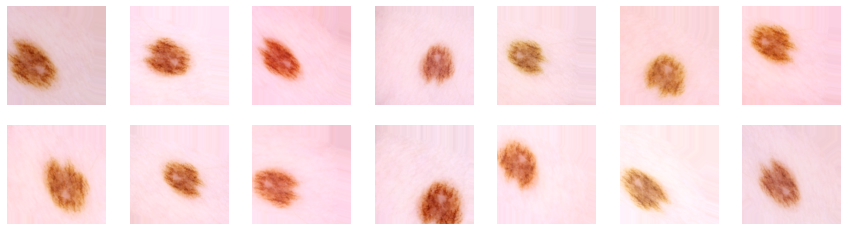

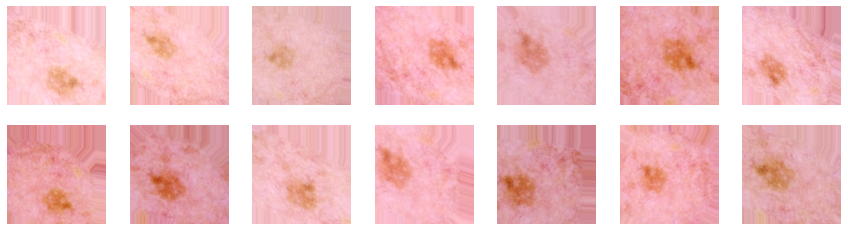

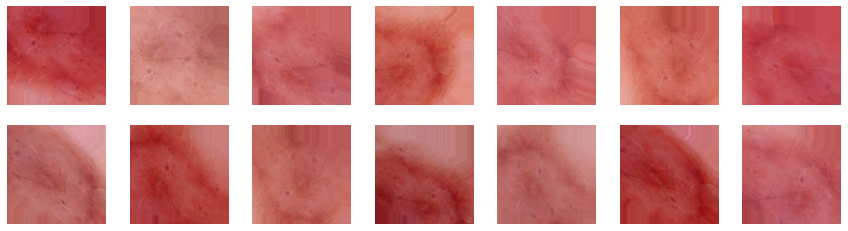

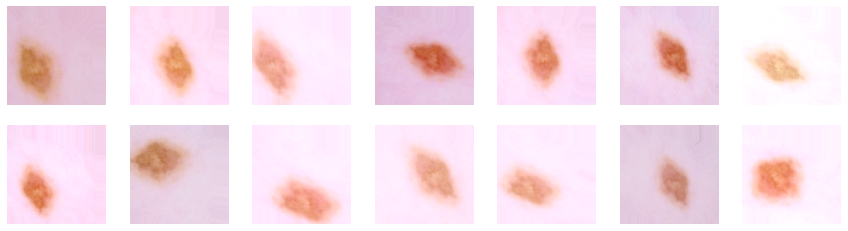

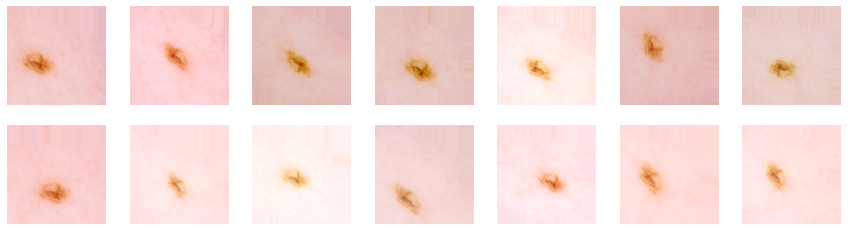

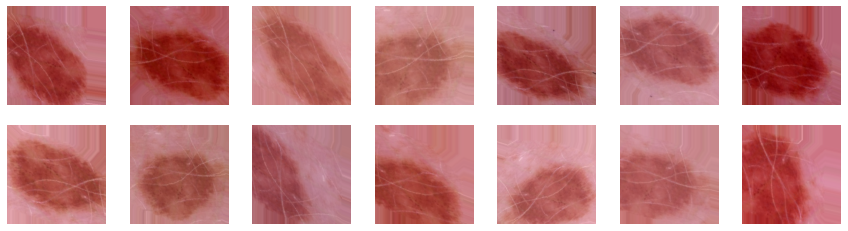

In [18]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
display_augmentation(all_elements, 6, data_augment)